### Things to Consider/Reminders:
* housing market is influenced by the economy, but regions can become "hot" leading to overpriced properties.
* find or create one feature for every type of measurement that a set of similar features is representing (ie. one feature/meta-feature for location, one for size of unit, etc.) 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn import svm
import missingno as msno
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

colors = sns.crayon_palette(['Tickle Me Pink', 'Atomic Tangerine', 'Fuzzy Wuzzy'])

# load dataset
train_df = pd.read_csv("./Sberbank/train.csv", parse_dates=['timestamp'], index_col=False)
test_df = pd.read_csv("./Sberbank/test.csv", parse_dates=['timestamp'], index_col=False)
macro_df = pd.read_csv("./Sberbank/macro.csv", parse_dates=['timestamp'], index_col=False)

/Users/rezarad/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# add macro data to train and test data
train_df = pd.merge(train_df, macro_df, how='left', on='timestamp')
test_df = pd.merge(test_df, macro_df, how='left', on='timestamp')

# add month, day, year to train and test data
train_df['month'] = train_df['timestamp'].dt.month
train_df['day'] = train_df['timestamp'].dt.day
train_df['year'] = train_df['timestamp'].dt.year

In [3]:
# merge training and test data set

frames = [train_df, test_df]

df = pd.concat(frames)

In [82]:
df_important = df.loc[:, ['timestamp', 'full_sq',
                          'life_sq', 'floor', 'max_floor', 'material',
                          'build_year', 'num_room',
                          'kitch_sq', 'state',
                          'product_type', 'sub_area',
                          'indust_part', 'school_education_centers_raion',
                          'sport_objects_raion', 'culture_objects_top_25_raion',
                          'oil_chemistry_raion', 'metro_min_avto',
                          'green_zone_km', 'industrial_km',
                          'kremlin_km', 'radiation_km',
                          'ts_km', 'fitness_km',
                          'stadium_km', 'additional_education_km',
                          'cafe_count_1500_price_500', 'cafe_count_1500_price_high',
                          'cafe_count_2000_price_2500', 'trc_sqm_5000',
                          'cafe_count_5000', 'cafe_count_5000_price_high',
                          'gdp_quart', 'cpi',
                          'ppi', 'usdrub',
                          'eurrub', 'gdp_annual',
                          'rts', 'micex',
                          'micex_cbi_tr', 'deposits_rate',
                          'mortgage_rate', 'income_per_cap',
                          'salary', 'labor_force',
                          'unemployment', 'employment', 'price_doc']]

### Functions for Scaling/Normalizing/Reshaping

In [4]:
# rescale data
def rescale(feature):
    return feature.values.reshape(-1,1)

# standardize data
from sklearn.preprocessing import StandardScaler

def standardize(feature):
    scaler = StandardScaler().fit(feature)
    return scaler.transform(feature)

# normalize data
from sklearn.preprocessing import Normalizer

def normalize(feature):
    scaler = Normalizer().fit(feature)
    return scaler.transform(feature)

In [5]:
def reshape_feature(feature):
    preprocess_df = rescale(feature)
    preprocess_df = standardize(feature)
    preprocess_df = normalize(feature)
    return preprocess_df[0]

### Macro start and end date

In [6]:
print "macro.csv start date: {0}".format(macro_df['timestamp'].min())
print "macro.csv end date: {0}".format(macro_df['timestamp'].max())

macro.csv start date: 2010-01-01 00:00:00
macro.csv end date: 2016-10-19 00:00:00


#### Number of null features in metro features

In [7]:
metro_features = ['metro_min_avto', 'metro_km_avto', 'metro_km_walk', 'metro_min_walk', 'price_doc']
metro_df = train_df.loc[:, metro_features]

metro_df.apply(lambda x: x.isnull()).sum()

metro_min_avto     0
metro_km_avto      0
metro_km_walk     25
metro_min_walk    25
price_doc          0
dtype: int64

In [8]:
metro_df_nonull = metro_df.where(lambda x: x.notnull())

In [9]:
corr = metro_df_nonull.corr()

corr

,metro_min_avto,metro_km_avto,metro_km_walk,metro_min_walk,price_doc
metro_min_avto,1.000000,0.945035,0.938710,0.938710,-0.192180
metro_km_avto,0.945035,1.000000,0.986754,0.986754,-0.179412
metro_km_walk,0.938710,0.986754,1.000000,1.000000,-0.182786
metro_min_walk,0.938710,0.986754,1.000000,1.000000,-0.182786
price_doc,-0.192180,-0.179412,-0.182786,-0.182786,1.000000


* **`metro_min_avto`** shows the strongest correlation with price out of the 4 metro features.

### Cleaning/Fixing Missing and Incorrect Values

In [10]:
# Cleaning values with incorrect information 
train_df.loc[train_df['state'] == 33, 'status'] = 3
train_df = train_df.loc[train_df['id'] != 24718] 
train_df = train_df.loc[train_df['floor'] != 0] 


#### Cleaning the build year

In [ ]:
train_df.loc[train_df['build_year'] == 20052009, 'build_year'] = 2009
train_df.loc[train_df['build_year'] == 215, 'build_year'] = 2015
train_df = train_df.loc[train_df['build_year'] != 4965, :]
df.loc[df['build_year'] == 0, 'build_year'] = 2015
df.loc[df['build_year'] == 1, 'build_year'] = 2016
df.loc[df['build_year'] == 2, 'build_year'] = 2017

In [37]:
print np.sum(df['build_year'].isnull())
print len(df['build_year'])

print 14654.0/38133

14654
38133
0.384286575932


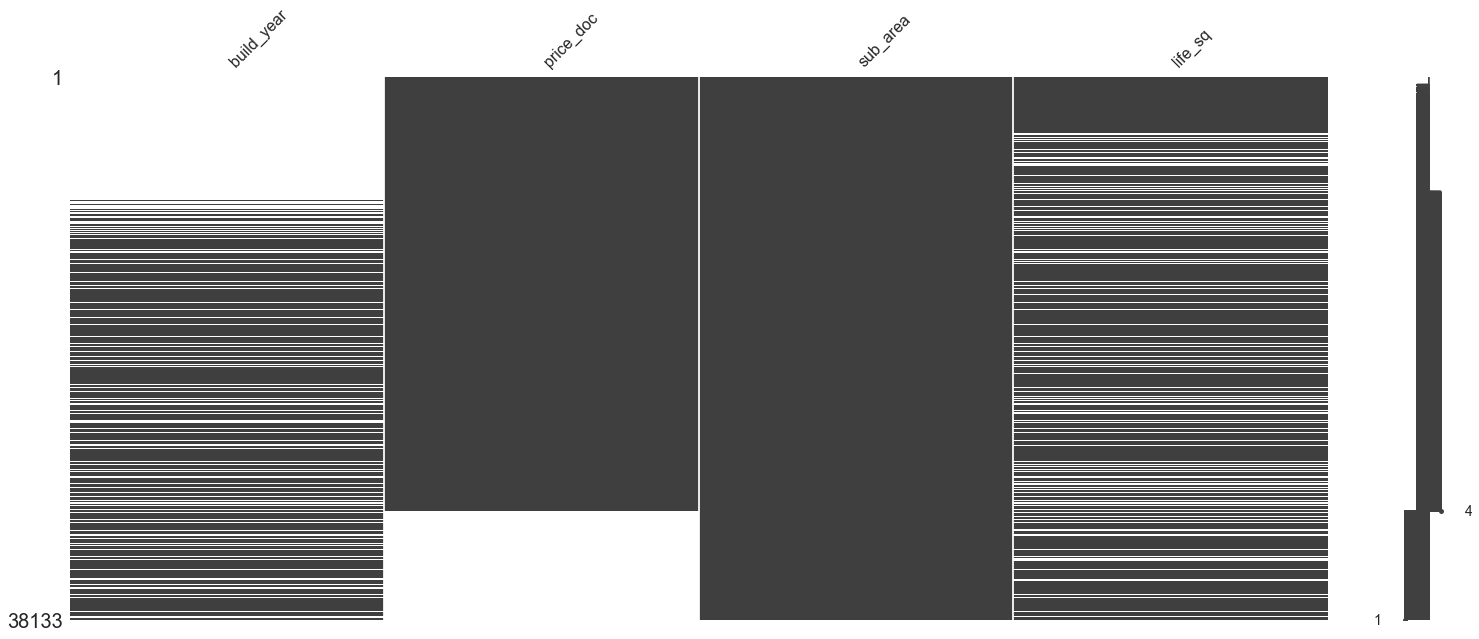

In [73]:
filtered_data = msno.nullity_filter(df, filter='bottom', n=40, p=0.9) # or filter='top'
msno.matrix(df[['build_year', 'price_doc', 'sub_area', 'life_sq']])

In [50]:
df.loc[df['build_year'].notnull(),['build_year', 'price_doc']].corr()

df[['sub_area', 'price_doc']].groupby(['sub_area'], sort=True).mean()

,price_doc
sub_area,
Ajeroport,9.888950e+06
Akademicheskoe,1.057576e+07
Alekseevskoe,8.978796e+06
Altuf'evskoe,5.516202e+06
Arbat,1.579480e+07
Babushkinskoe,7.637642e+06
Basmannoe,1.158772e+07
Begovoe,1.062361e+07
Beskudnikovskoe,6.770565e+06


In [68]:
df.loc[df['build_year'].isnull(), ['build_year', 'price_doc', 'sub_area', 'timestamp']]

,build_year,price_doc,sub_area,timestamp
0,NaN,5850000.0,Bibirevo,2011-08-20
1,NaN,6000000.0,Nagatinskij Zaton,2011-08-23
2,NaN,5700000.0,Tekstil'shhiki,2011-08-27
3,NaN,13100000.0,Mitino,2011-09-01
4,NaN,16331452.0,Basmannoe,2011-09-05
5,NaN,9100000.0,Nizhegorodskoe,2011-09-06
6,NaN,5500000.0,Sokol'niki,2011-09-08
7,NaN,2000000.0,Bibirevo,2011-09-09
8,NaN,5300000.0,Koptevo,2011-09-10
9,NaN,2000000.0,Kuncevo,2011-09-13


Visualization of missing values in 50 features where build year is 0

In [80]:
build_0 = train_df.loc[train_df['build_year'] == 0, :]

filtered_data = msno.nullity_filter(build_0, filter='bottom', n=50, p=0.9) # or filter='top'

In [85]:
feat_impt = ['full_sq', 'cafe_count_5000', 'metro_min_avto', 
'additional_education_km', 'stadium_km', 'ts_km', 
'kremlin_km', 'green_zone_km', 'trc_sqm_5000',
'radiation_km', 'fitness_km', 'micex_cbi_tr']

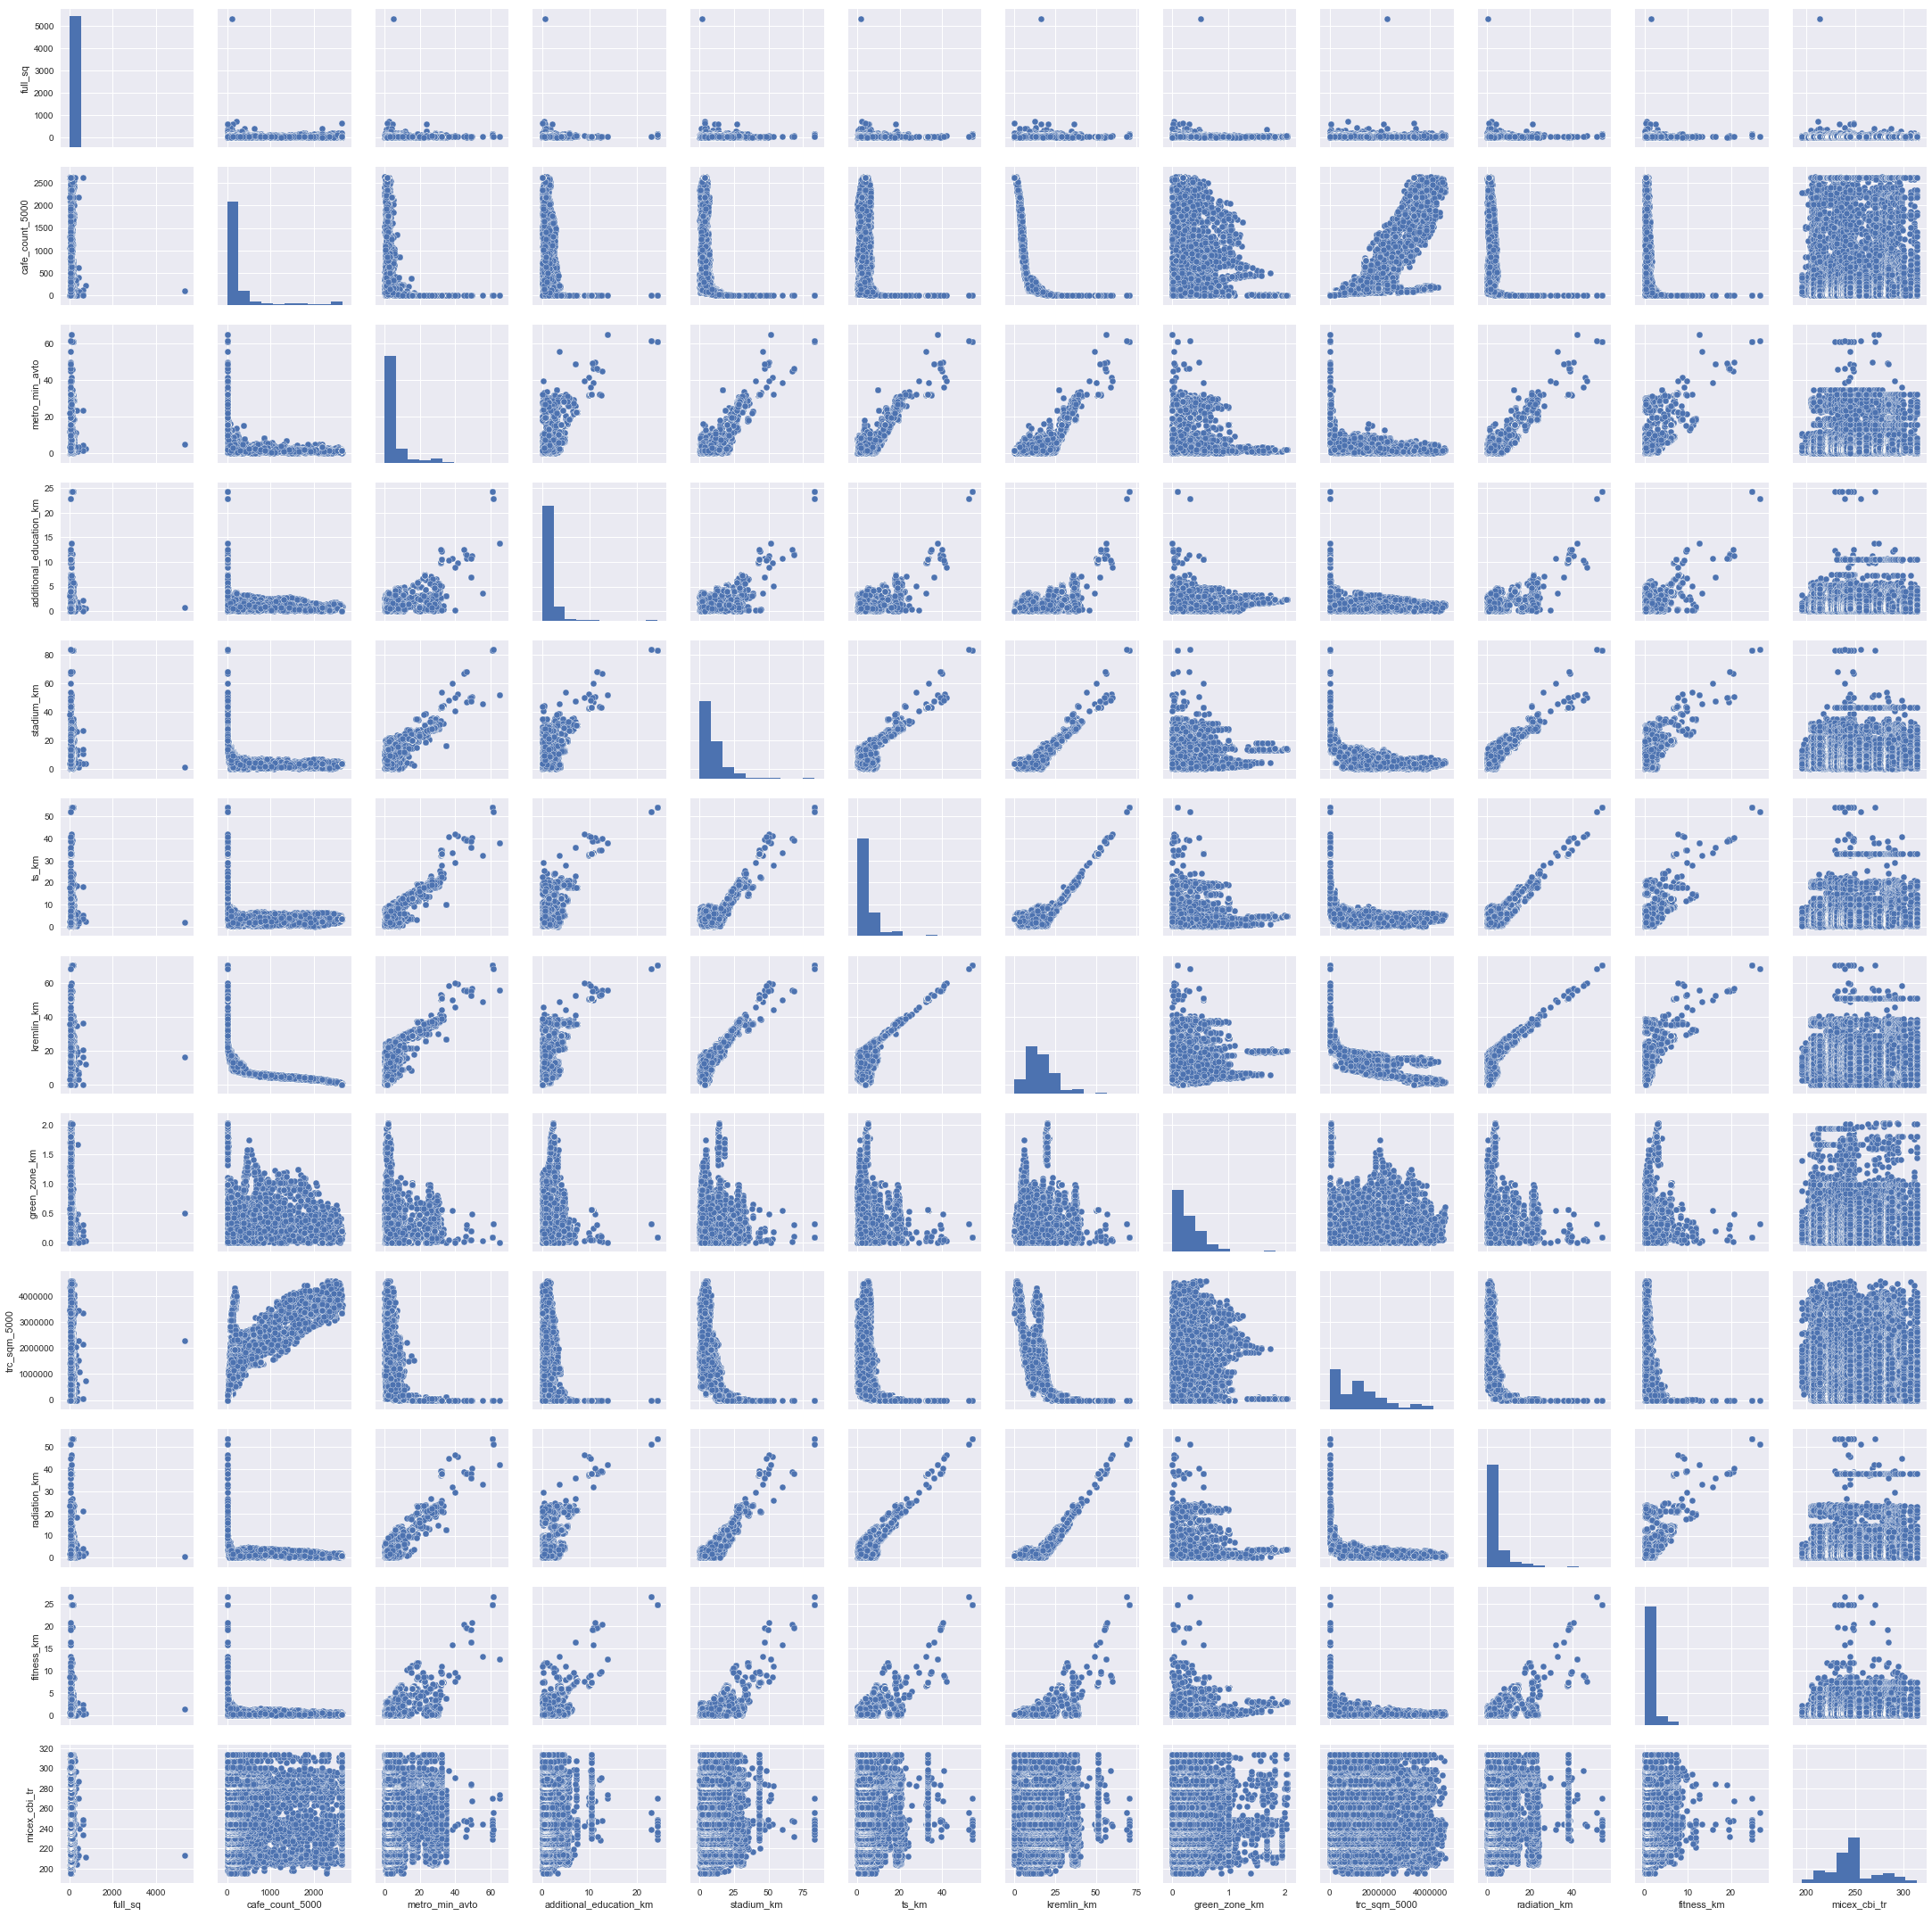

In [86]:
import seaborn as sns

sns.set()
sns.pairplot(df[feat_impt])

In [13]:
(build_0.nunique()/len(build_0))

id                                        1.000000
timestamp                                 0.607211
full_sq                                   0.144213
life_sq                                   0.151803
floor                                     0.045541
max_floor                                 0.043643
material                                  0.009488
build_year                                0.001898
num_room                                  0.011385
kitch_sq                                  0.032258
state                                     0.005693
product_type                              0.003795
sub_area                                  0.075901
area_m                                    0.075901
raion_popul                               0.075901
green_zone_part                           0.075901
indust_part                               0.074004
children_preschool                        0.075901
preschool_quota                           0.053131
preschool_education_centers_rai

* build_year = 0 are all from the same date-range. 

In [14]:
build_0['timestamp'].min()

Timestamp('2013-07-25 00:00:00')

In [15]:
build_0['timestamp'].max()

Timestamp('2015-06-29 00:00:00')

In [16]:
df.groupby('build_year').count()

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,...,water_treatment_km,work_all,work_female,work_male,workplaces_km,year,young_all,young_female,young_male,zd_vokzaly_avto_km
build_year,,,,,,,,,,,,,,,,,,,,,
0.0,899,899,899,899,899,899,899,899,899,899,...,899,899,899,899,899,530,899,899,899,899
1.0,555,555,555,555,555,555,555,555,555,555,...,555,555,555,555,555,368,555,555,555,555
2.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
3.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
20.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
71.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
215.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2
1691.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1860.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [17]:
df.loc[df['build_year'] == 0]

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,...,water_treatment_km,work_all,work_female,work_male,workplaces_km,year,young_all,young_female,young_male,zd_vokzaly_avto_km
9441,506,245,261,646,311,336,275,133,143,3796,...,17.575450,2566,1211,1356,11.582101,2013.0,574,277,297,28.662663
10142,3112,1512,1600,3831,1858,1973,1706,844,862,55710,...,0.387777,13331,6661,6670,5.599071,2013.0,3459,1677,1782,24.061214
10260,2756,1333,1423,3523,1694,1830,1497,721,777,1566,...,13.997580,13996,6602,7394,9.907037,2013.0,3128,1510,1618,30.927687
10294,3112,1512,1600,3831,1858,1973,1706,844,862,55710,...,0.387777,13331,6661,6670,5.599071,2013.0,3459,1677,1782,24.061214
10331,24934,12152,12782,32063,15550,16513,13087,6442,6645,3292,...,15.893560,120381,60341,60040,0.249131,2013.0,28563,13883,14680,16.400814
10347,506,245,261,646,311,336,275,133,143,3796,...,20.126930,2566,1211,1356,11.458858,2013.0,574,277,297,25.554218
10349,11252,5336,5916,14884,7063,7821,5879,2784,3095,19401,...,4.649307,63388,31575,31813,1.875823,2013.0,13028,6193,6835,10.679909
10628,9864,4702,5162,13145,6381,6764,4969,2412,2557,15474,...,20.171540,52030,26489,25541,1.669866,2013.0,11205,5347,5858,6.550922
10653,3112,1512,1600,3831,1858,1973,1706,844,862,55710,...,0.387777,13331,6661,6670,5.599071,2013.0,3459,1677,1782,24.061214
10665,20140,9609,10531,26095,12498,13597,10190,4856,5334,11372,...,18.119000,93843,46574,47269,1.099151,2013.0,22961,10922,12039,14.096796


In [18]:
df.loc[df['build_year'] == 2016, ]

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,...,water_treatment_km,work_all,work_female,work_male,workplaces_km,year,young_all,young_female,young_male,zd_vokzaly_avto_km
10706,24934,12152,12782,32063,15550,16513,13087,6442,6645,3292,...,15.944430,120381,60341,60040,0.241203,2013.0,28563,13883,14680,16.373795
10955,24934,12152,12782,32063,15550,16513,13087,6442,6645,3292,...,15.893560,120381,60341,60040,0.249131,2013.0,28563,13883,14680,16.400814
14531,15224,7351,7873,19215,9226,9989,8371,4015,4356,15495,...,13.586230,79011,37942,41069,4.556721,2014.0,16928,8213,8715,11.831706
14638,322,156,166,411,198,214,175,85,91,628,...,12.817370,1633,771,863,13.886521,2014.0,365,177,189,38.533871
14666,24934,12152,12782,32063,15550,16513,13087,6442,6645,3292,...,15.893560,120381,60341,60040,0.249131,2014.0,28563,13883,14680,16.400814
14709,9955,5120,4835,12508,6443,6065,4237,2158,2079,23480,...,10.378040,43921,22020,21901,1.091507,2014.0,11272,5802,5470,4.060430
16725,21679,10596,11083,27533,13457,14076,10955,5372,5583,30980,...,16.479800,100601,47986,52615,0.603513,2014.0,24814,12127,12687,7.940142
17114,3112,1512,1600,3831,1858,1973,1706,844,862,55710,...,1.291558,13331,6661,6670,5.254920,2014.0,3459,1677,1782,25.284274
17349,3112,1512,1600,3831,1858,1973,1706,844,862,55710,...,0.387777,13331,6661,6670,5.599071,2014.0,3459,1677,1782,24.061214
18097,3112,1512,1600,3831,1858,1973,1706,844,862,55710,...,0.387777,13331,6661,6670,5.599071,2014.0,3459,1677,1782,24.061214


In [28]:

df.loc[:, 'build_year']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
         ...  
7632    1967.0
7633    2015.0
7634    1984.0
7635       NaN
7636    1953.0
7637    2017.0
7638       NaN
7639    1996.0
7640    2016.0
7641    2015.0
7642       NaN
7643    2013.0
7644    2012.0
7645    2016.0
7646    2016.0
7647    2014.0
7648    2016.0
7649       NaN
7650    2017.0
7651    2000.0
7652    2016.0
7653    2016.0
7654    2016.0
7655       NaN
7656       NaN
7657    1973.0
7658       NaN
7659    2016.0
7660    1977.0
7661    1973.0
Name: build_year, Length: 38133, dtype: float64

**majority of build_year at 0 are in the Poselenie sub-areas**

In [89]:
df[['cafe_count_1500_price_500','sub_area']]

,cafe_count_1500_price_500,sub_area
0,14,Bibirevo
1,6,Nagatinskij Zaton
2,4,Tekstil'shhiki
3,5,Mitino
4,70,Basmannoe
5,3,Nizhegorodskoe
6,12,Sokol'niki
7,13,Bibirevo
8,4,Koptevo
9,2,Kuncevo


In [92]:
df.to_csv('./Sberbank/merged_data_cleaned_052417.csv', index=False)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7652, 7653, 7654, 7655, 7656, 7657, 7658, 7659, 7660, 7661],
           dtype='int64', length=38133)